# Rapid Exploration

In [1]:
%matplotlib inline
#%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
from sklearn.cluster import KMeans
import  PIL
import cv2 as cv
from scipy import ndimage, misc
import cv2


from puzzle import Puzzle
from puzzle_piece import PuzzlePiece

In [3]:
# Auto reload rules:
%load_ext autoreload
%autoreload 1
%aimport puzzle
%aimport puzzle_piece

In [4]:
IMAGE_PATH = '../data/images/green_screen_ordered.jpg'

In [5]:
plt.rcParams['figure.figsize'] = [15, 15]

# Show base image

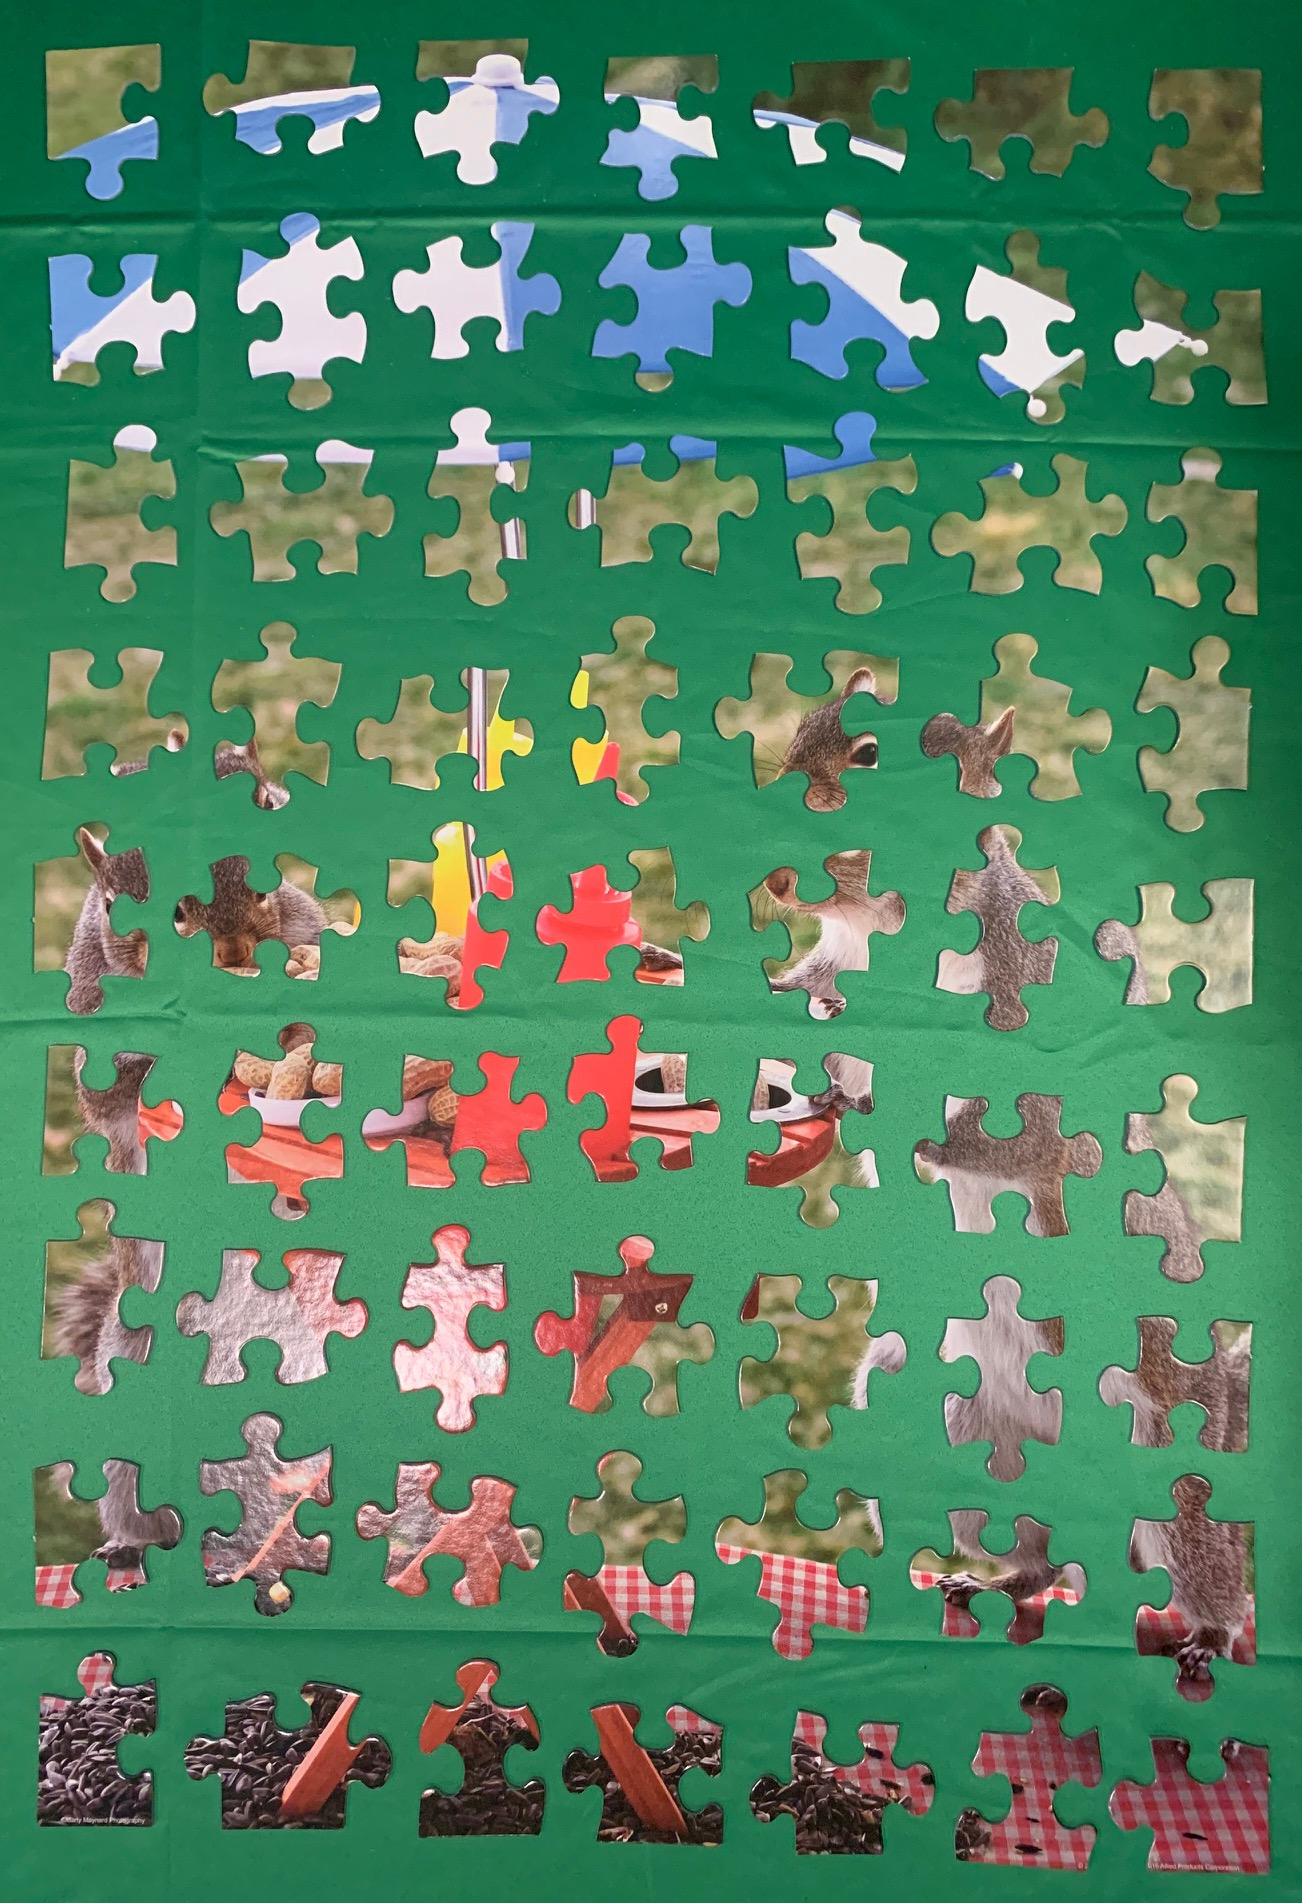

In [6]:
Image(IMAGE_PATH, width=500)

# Load puzzle and analyze colors

In [7]:
puzzle = Puzzle(IMAGE_PATH)

# Convert to hsv

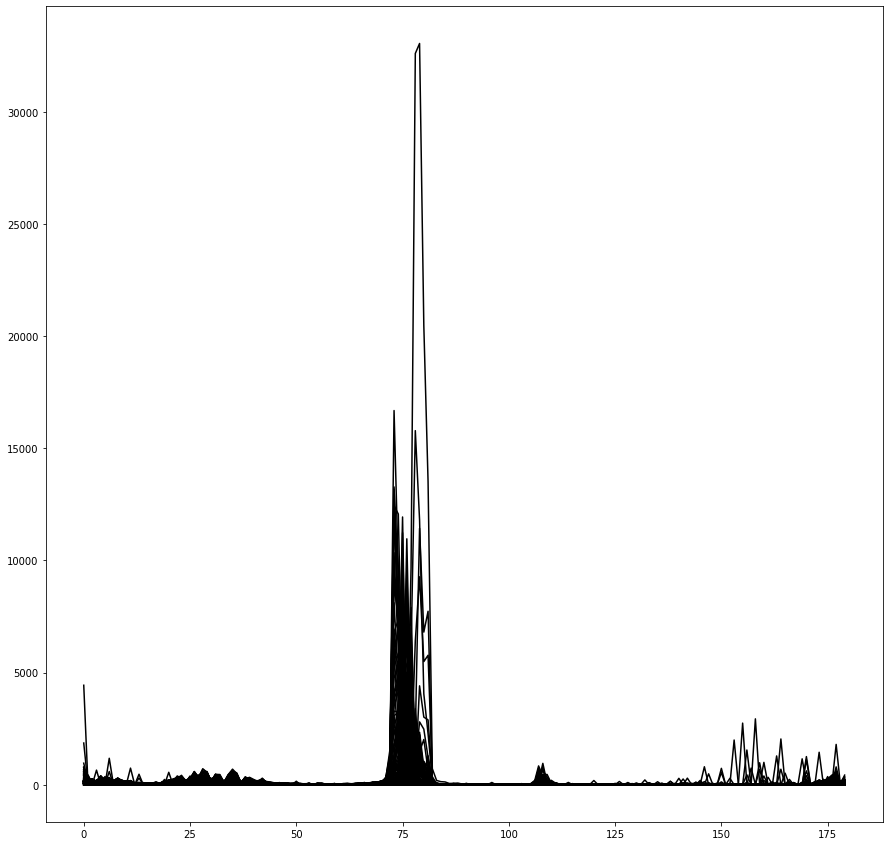

In [8]:
hist = cv.calcHist([puzzle.hsv], [0,1], None, [180, 256], [0,180,0,256])
plt.plot(hist, color='k')
plt.show()

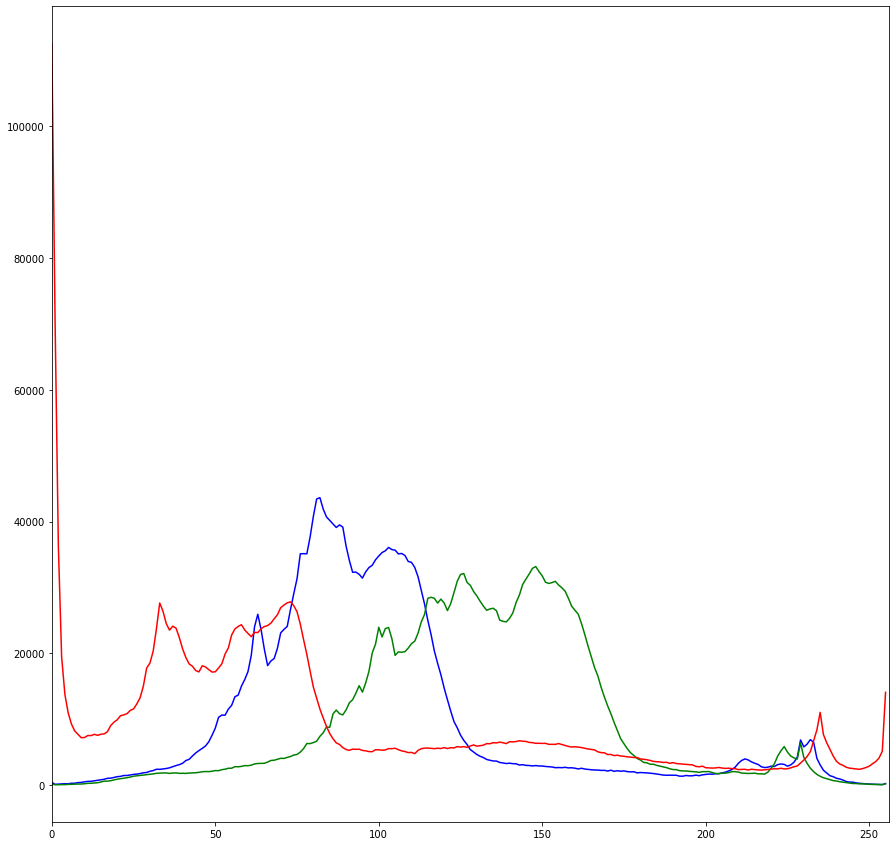

In [9]:
for i, col in enumerate(['b', 'g', 'r']):
    hist = cv.calcHist([puzzle.image], [i], None, [256], [0, 256])
    plt.plot(hist, color = col)
    plt.xlim([0, 256])
    
plt.show()

## Histogram to try to isolate green screen

In [10]:
def show_img_compar(img_1, img_2 ):
    f, ax = plt.subplots(1, 2, figsize=(10,10))
    ax[0].imshow(img_1)
    ax[1].imshow(img_2)
    ax[0].axis('off') #hide the axis
    ax[1].axis('off')
    f.tight_layout()
    plt.show()

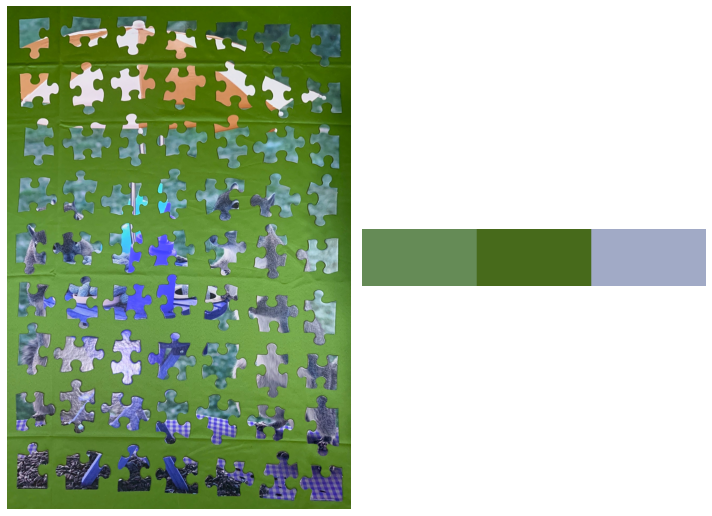

In [11]:
def palette(clusters):
    width=300
    palette = np.zeros((50, width, 3), np.uint8)
    steps = width/clusters.cluster_centers_.shape[0]
    for idx, centers in enumerate(clusters.cluster_centers_): 
        palette[:, int(idx*steps):(int((idx+1)*steps)), :] = centers
    return palette

clt_3 = KMeans(n_clusters=3)
clt_3.fit(puzzle.image.reshape(-1, 3))
show_img_compar(puzzle.image, palette(clt_3))

# Green screening

In [12]:
src = cv.imread(IMAGE_PATH)
imgRGB = cv.cvtColor(src, cv.COLOR_BGR2RGB)
imgHSV = cv.cvtColor(imgRGB, cv.COLOR_BGR2HSV)

imgRGB = ndimage.rotate(imgRGB, 90)
imgHSV = ndimage.rotate(imgHSV, 90)

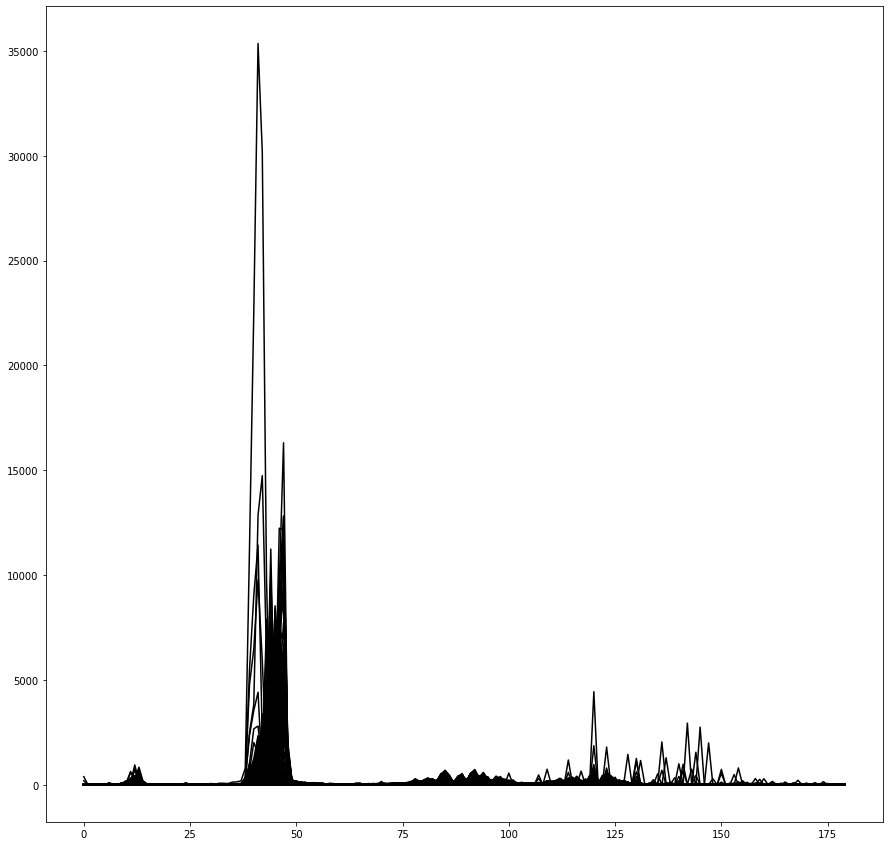

In [13]:
hist = cv.calcHist([imgHSV], [0,1], None, [180, 256], [0,180,0,256])
plt.plot(hist, color='k')
plt.show()

In [14]:
for i, val in enumerate(np.max(hist[30:60,:], axis=1)):
    print(f"{30+i}: {val}")

30: 64.0
31: 31.0
32: 74.0
33: 64.0
34: 58.0
35: 126.0
36: 137.0
37: 183.0
38: 785.0
39: 11383.0
40: 22546.0
41: 35356.0
42: 30186.0
43: 9755.0
44: 11240.0
45: 8533.0
46: 12237.0
47: 16310.0
48: 2040.0
49: 249.0
50: 181.0
51: 125.0
52: 117.0
53: 82.0
54: 104.0
55: 68.0
56: 70.0
57: 44.0
58: 58.0
59: 51.0


63


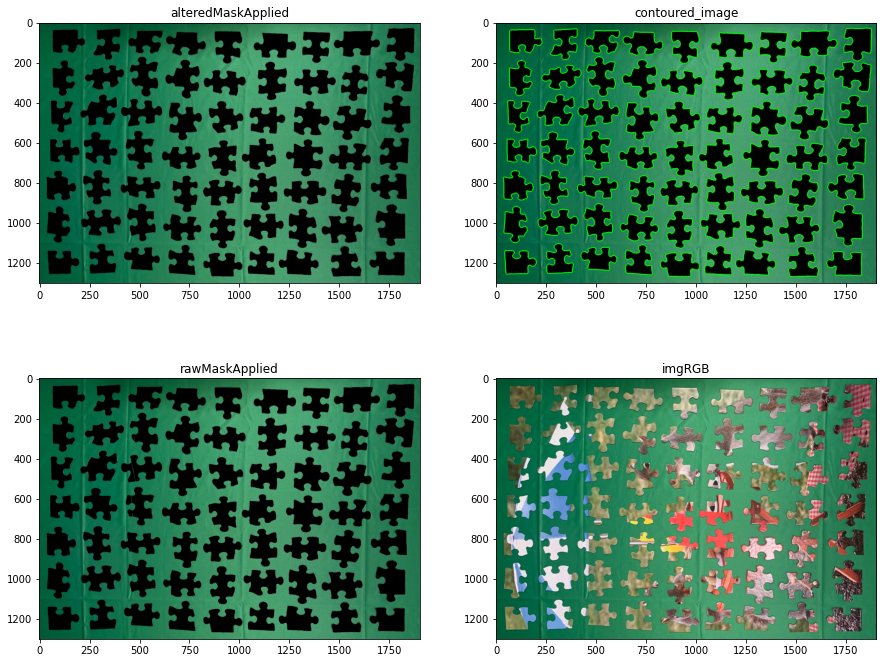

In [15]:
plt.rcParams['figure.figsize'] = [15, 12]

lower = np.array([35, 50, 0])    #Lower values of HSV range; Green have Hue value equal 120, but in opencv Hue range is smaler [0-180]
upper = np.array([52, 255, 255])  #Uppervalues of HSV range


imgRange = cv.inRange(imgHSV, lower, upper)
flipMaskImg = cv.bitwise_not(imgRange)

# Adjust the range threshold.
alteredMask = np.array(flipMaskImg, copy=True)
alteredMask = cv.dilate(alteredMask, np.ones((3,3),np.uint8), 1)
alteredMask = cv.erode(alteredMask, np.ones((3,3),np.uint8), 1)

alteredMask = cv.bitwise_not(alteredMask)

# Construct masked images.
rawMaskApplied = cv.bitwise_and(imgRGB, imgRGB, mask = imgRange)
alteredMaskApplied = cv.bitwise_and(imgRGB, imgRGB, mask = alteredMask)

# Generate rough contours.
contoured_image = np.array(alteredMaskApplied, copy=True)
contours, hierarchy = cv.findContours(alteredMask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# Filter out contours too big or small.
med = np.median([cv.contourArea(c) for c in contours])
contours_trimmed = []
for c in contours:
    con_area = cv.contourArea(c)
    if con_area < 2*med and con_area > 0.5*med:
        contours_trimmed.append(c)

cv.drawContours(contoured_image, contours_trimmed, -1, (0,255,0), 3)

print(len(contours_trimmed))


plt.figure(1)

ax1 = plt.subplot(221)
plt.imshow(alteredMaskApplied)
ax1.title.set_text('alteredMaskApplied')


ax2 = plt.subplot(222)
plt.imshow(contoured_image)
ax2.title.set_text('contoured_image')

ax3 = plt.subplot(223)
plt.imshow(rawMaskApplied)
ax3.title.set_text('rawMaskApplied')

ax4 = plt.subplot(224)
plt.imshow(imgRGB)
ax4.title.set_text('imgRGB')

plt.show()

# Create Puzzle Pieces

In [16]:
puzzle.create_pieces(contoured_image, contours_trimmed)


# Label indexes on image

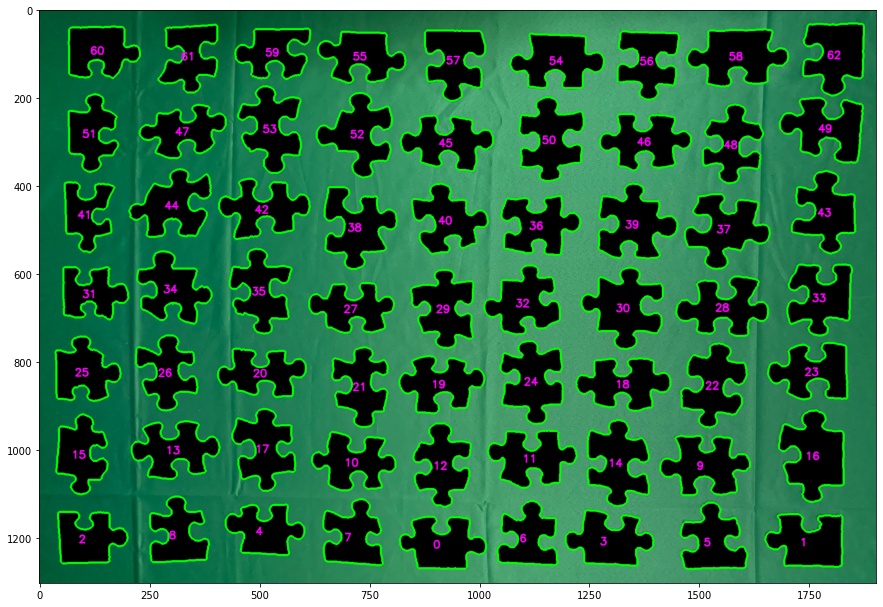

In [17]:
plt.imshow(puzzle.labeled_pieces)
plt.show()

# Analyzing contour output

In [18]:
# How deep it goes
puzzle.pieces[0].contour[0][0][1]

1152

In [19]:
# What the dimensions mean
# contours_trimmed[0][0][0][1]
# 63 length pieces, 244 points for piece 0, [x, y dim]
puzzle.pieces[0].contour[0]

array([[ 877, 1152]], dtype=int32)

In [20]:
# Top and bottom 5 number of points in contours
s = sorted([len(p.contour) for p in puzzle.pieces])
s[0:5] + s[-6: -1]

[165, 178, 205, 223, 223, 343, 347, 349, 357, 358]

# Show rects

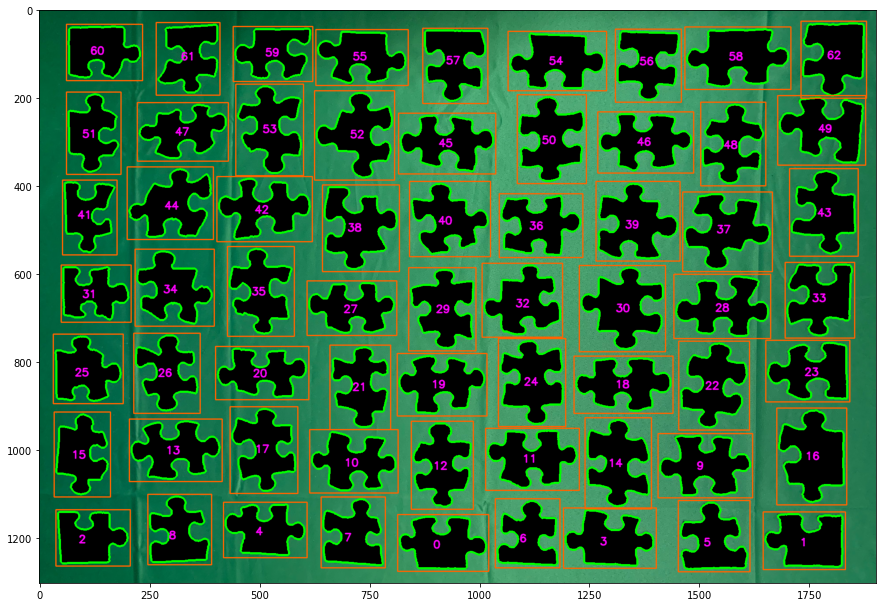

In [21]:
imageLabeledWRects = np.copy(puzzle.labeled_pieces)
for piece in puzzle.pieces:
    x, y, w, h = piece.dims
    cv.rectangle(imageLabeledWRects,(x,y),(x+w,y+h),(255,100,0),2)
plt.imshow(imageLabeledWRects)
plt.show()

# Explore different epsilons for initializing polygon based contours

Pieces worth exploring
* Corner: 2
* Edge: 25, 57
* Center pieces: 13, 30, 37, 44, 47

In [22]:
def renderPiecePolys(index):

    piece = puzzle.pieces[index]
    contour, (x,y,w,h) = piece.contour, piece.dims
    arc_length = piece.arc_length
    img = piece.image


    plt.figure(1)

    ax1 = plt.subplot(231)
    plt.imshow(img)
    ax1.title.set_text(f'Default image - Points: {len(contour)}')

    levels = [.005, .01, .02, .03, .05]
    for i, ep in enumerate(levels):
        sp = 232 + i
        ax = plt.subplot(sp)
        approxContour = cv2.approxPolyDP(contour, ep * arc_length, True)
        subPiece = np.copy(img)
        subPiece = cv2.drawContours(subPiece, [approxContour], 0, (255,0,255), offset = (-x,-y))
        ax.imshow(subPiece)
        ax.title.set_text(f'Epsilon percent: {ep} - Points: {len(approxContour)}')

    plt.show()


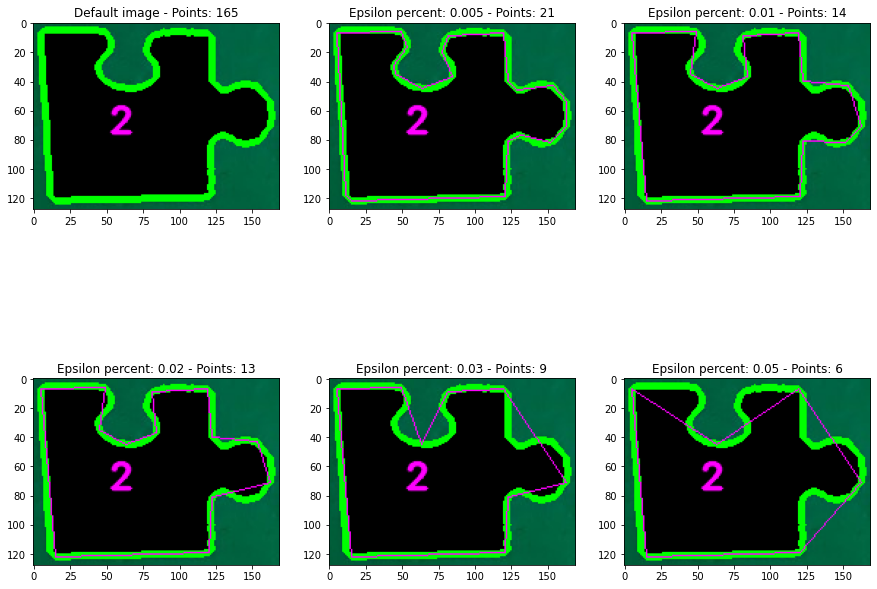

In [23]:
renderPiecePolys(2)

# Exploring concavities

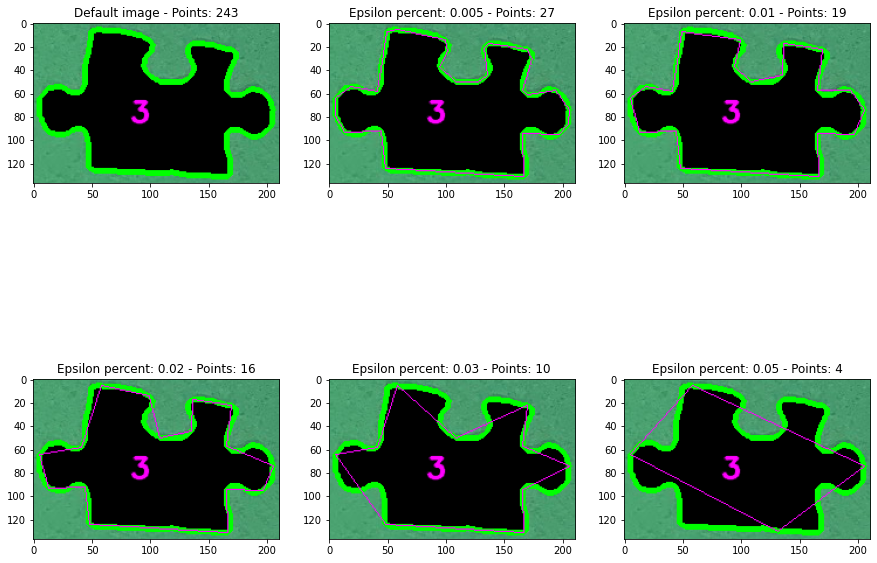

In [24]:
renderPiecePolys(3)